### Spark Setup

May not be required when working on google cloud machines

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark
import findspark
findspark.init("spark-3.0.0-bin-hadoop3.2")
from pyspark.sql import SparkSession

### Project setup

In [ ]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm
import sys

### Download Dataset

In [ ]:
!pip install -q kaggle
!export PATH="/home/$USER/.local/bin/bin:$PATH"
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
import kaggle # Restart the kernel after this
kaggle.api.authenticate()
kaggle.api.dataset_download_files('jeffheaton/glasses-or-no-glasses', path='./', unzip=True)

'!pip install -q kaggle\n!export PATH="/home/$USER/.local/bin/bin:$PATH"\n!mkdir ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\nimport kaggle # Restart the kernel after this\nkaggle.api.authenticate()\nkaggle.api.dataset_download_files(\'jeffheaton/glasses-or-no-glasses\', path=\'./\', unzip=True)'

### Clone repository

In [1]:
!git clone https://github.com/Ale-Ba2lero/CNN-FromScratch
%cd CNN-FromScratch/
!zip model.zip ./model

[Errno 2] No such file or directory: '/home/$USER/'
/content
rm: cannot remove 'CNN-FromScratch/': No such file or directory
Cloning into 'CNN-FromScratch'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (575/575), done.
remote: Compressing objects: 100% (380/380), done.
remote: Total 575 (delta 397), reused 366 (delta 191), pack-reused 0
Receiving objects: 100% (575/575), 109.23 KiB | 2.18 MiB/s, done.
Resolving deltas: 100% (397/397), done.
/content/CNN-FromScratch


In [ ]:
sc.addPyFile("model.zip")
from model.loss import CategoricalCrossEntropy
from model.layers.conv2d import Conv2D
from model.layers.dense import Dense
from model.layers.maxpool2d import MaxPool2D
from model.layers.flatten import Flatten
from model.layers.relu import ReLU, LeakyReLU
from model.layers.softmax import Softmax
from model.layers.dropout import Dropout
from model.utility import Metrics
from model.neural_network import NeuralNetwork

### Parameters

In [ ]:
DATASET_SIZE = 500
IMAGE_SIZE = 80
STEP_SIZE = 1e-3
N_EPOCHS = 50
BATCH_SIZE = 16
N_BATCHES = DATASET_SIZE / BATCH_SIZE 

CPUS = 4
NODES = 5
WORKERS = CPUS * NODES

### Import dataset

In [ ]:
ds_path = "./train.csv"
directory = "./faces-spring-2020/faces-spring-2020/"

ds = pd.read_csv(ds_path)
labels = ds.iloc[:DATASET_SIZE, -1].to_numpy()

### Dataset preprocessing

In [ ]:
data = []
for x in tqdm(range(DATASET_SIZE)):
    img_path = f'{directory}face-{x + 1}.png'
    img = Image.open(img_path)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
    img = np.array(img)
    #img = (img - np.min(img)) / np.ptp(img) # Normalise [0,1]
    data.append(img)
data = np.array(data)

100%|█████████████████████████████████████████| 500/500 [00:22<00:00, 21.95it/s]


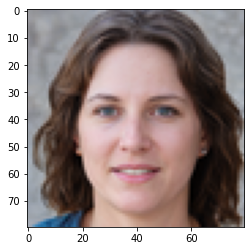

In [ ]:
plt.imshow(data[8])

In [ ]:
def normalize_meanstd(a, axis=None): 
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.sqrt(((a - mean)**2).mean(axis=axis, keepdims=True))
    return (a - mean) / std

data = normalize_meanstd(data, axis=(1,2))

### Split training set and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=46)

### Split the dataset into batches

In [ ]:
INPUT_SHAPE = X_train.shape[1:]
X_batch = np.array_split(X_train, N_BATCHES)
y_batch = np.array_split(y_train, N_BATCHES)

In [ ]:
X_batch = np.array(X_batch)
y_batch = np.array(y_batch)

### Build the RDD

In [ ]:
X_rdd = sc.parallelize(X_batch, WORKERS)
y_rdd = sc.parallelize(y_batch, WORKERS)
rdd = X_rdd.zip(y_rdd)

### Model Build

In [ ]:
nn = NeuralNetwork([
    Conv2D(num_filters=16, kernel_size=5, padding="same"), ReLU(),
    Conv2D(num_filters=16, kernel_size=3, padding="same"), ReLU(),
    Conv2D(num_filters=32, kernel_size=3, padding="same"), ReLU(),MaxPool2D(),
    Flatten(),
    Dense(128), ReLU(), Dropout(0.1),
    Dense(128), ReLU(), Dropout(0.1),
    Dense(2), Softmax()
], CategoricalCrossEntropy())
nn.layer_setup(INPUT_SHAPE)

### Model train

In [ ]:
def epoch_train(batch):
    X_batch, y_batch = batch[0], batch[1]
    output = broadcastNN.value.forward(X_batch)
    loss, acc, d_score = broadcastNN.value.loss_function.calculate(output, y_batch)
    broadcastNN.value.backward(d_score)
    deltas = broadcastNN.value.get_layers_delta()
    
    delta_ = []
    for key, value in deltas.items():
        temp = (key,value)
        delta_.append(temp)
    
    delta_.append(("loss",loss))
    delta_.append(("acc",acc))
    delta_.append(("count", 1))
    return delta_

In [ ]:
%%time
metrics = Metrics()
broadcastNN = sc.broadcast(nn)
for e in tqdm(range(N_EPOCHS)):
    nrdd = rdd.flatMap(lambda batch: epoch_train(batch)).reduceByKey(lambda a, b: np.add(a,b)).collect()
    deltas = {}
    for value in nrdd:
        deltas[value[0]]=value[1]

    train_loss = deltas["loss"] / deltas["count"] 
    train_acc = deltas["acc"] / deltas["count"]

    metrics.update(train_loss, train_acc, "train")  

    nn.set_layers_delta(deltas) 
    nn.weights_update(STEP_SIZE)
    broadcastNN.unpersist()
    broadcastNN.destroy()
    broadcastNN = sc.broadcast(nn)

    test_loss, test_acc = metrics.evaluate_model(X_test, y_test, nn.layers, nn.loss_function)
    metrics.update(test_loss, test_acc, "test")

### Model evaluation

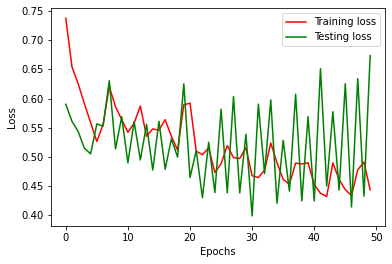

In [ ]:
train_loss = metrics.history['train_loss']
test_loss = metrics.history['test_loss']
epochs = range(0, N_EPOCHS)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'g', label='Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

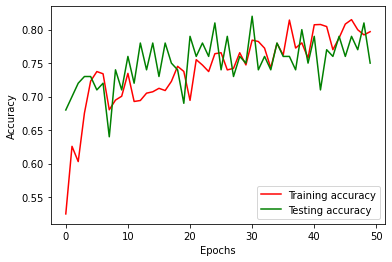

In [ ]:
train_acc = metrics.history['train_acc']
test_acc = metrics.history['test_acc']
epochs = range(0, N_EPOCHS)
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, test_acc, 'g', label='Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
%%time
train_loss, train_acc = metrics.evaluate_model(X_train, y_train, nn.layers, nn.loss_function)

print(f"train loss: {train_loss}")
print(f"train acc: {train_acc}")

train loss: 0.39981620082719743
train acc: 0.8275
CPU times: user 56.9 s, sys: 906 ms, total: 57.8 s
Wall time: 57.6 s


In [ ]:
test_loss, test_acc = metrics.evaluate_model(X_test, y_test, nn.layers, nn.loss_function)

print(f"val loss: {test_loss}")
print(f"val acc: {test_acc}")

val loss: 0.6736981744581254
val acc: 0.75
